## Imports

In [99]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

import joblib

## Global Variables

In [100]:
''' 

95 Percentile
IYW 1d 1.5%, 1hr 0.697%
JEF 1d 2.5%, 1hr 1.1%
TSLA 1d 4.3%, 1hr 1.65%
VGT 1d 1.41% 1hr 0.686%
VHT 1d 1.24%, 1hr 0.59%

'''

interval = '1d' # time interval for data point
history = '10y' # time period for total history
perc_inc = 0.025 # 1% increase or more from interval to interval
symbol = 'JEF' # tech etf 

## Yahoo Finance

In [101]:
stock_df = yf.download(tickers = symbol
                       , interval = interval
                       , period = history
                       , prepost = False
                      )

[*********************100%***********************]  1 of 1 completed


In [102]:
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-08-25,18.170446,18.471312,18.051924,18.416609,15.656408,1480500
2010-08-26,18.480429,18.690123,18.334555,18.361906,15.609903,1439700
2010-08-27,18.526014,19.383026,18.526014,19.346558,16.446978,2371900


In [103]:
stock_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-20,17.240000,17.500000,17.160000,17.459999,17.459999,842900
2020-08-21,17.440001,17.510000,17.230000,17.280001,17.280001,900200
2020-08-24,17.440001,17.639999,17.299999,17.600000,17.600000,1834000


## Create Percent Change

In [104]:
stock_df['Percent Change'] = (stock_df.Close - stock_df.Open) / (stock_df.Open + 0.00001)
stock_df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Percent Change
Date,,,,,,,
2010-08-25,18.170446,18.471312,18.051924,18.416609,15.656408,1480500,0.013547
2010-08-26,18.480429,18.690123,18.334555,18.361906,15.609903,1439700,-0.006413
2010-08-27,18.526014,19.383026,18.526014,19.346558,16.446978,2371900,0.044291


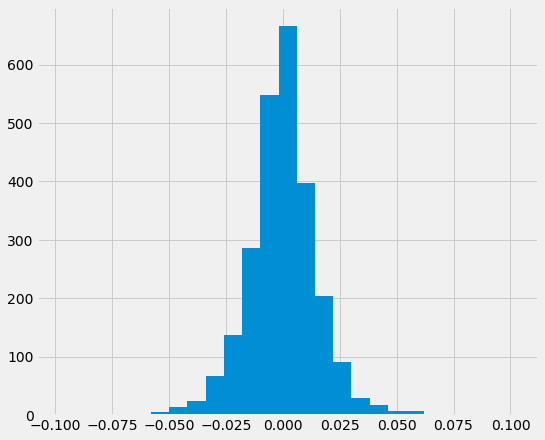

In [105]:
stock_df['Percent Change'].hist(bins=25);

In [106]:
stock_df['Percent Change'].quantile([0.95]) # 1 stdev from avg

0.95    0.024566
Name: Percent Change, dtype: float64

## High Minus Low Percent Change

In [107]:
stock_df['HL Percent Change'] = np.where(stock_df['Percent Change'] > 0
                                , (stock_df.High - stock_df.Low)/stock_df.Low
                                , (stock_df.Low - stock_df.High)/stock_df.High
                               )
stock_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change
Date,,,,,,,,
2010-08-25,18.170446,18.471312,18.051924,18.416609,15.656408,1480500,0.013547,0.023232
2010-08-26,18.480429,18.690123,18.334555,18.361906,15.609903,1439700,-0.006413,-0.019024
2010-08-27,18.526014,19.383026,18.526014,19.346558,16.446978,2371900,0.044291,0.046260
2010-08-30,19.300972,19.364792,19.073042,19.073042,16.214460,1137300,-0.011809,-0.015066
2010-08-31,18.908934,19.519783,18.817762,19.465080,16.547745,5267400,0.029412,0.037306


## Assign Direction

In [108]:
stock_df['Direction'] = np.where(stock_df['Percent Change'] > perc_inc
                                 , 1
                                 , 0
                                )

In [109]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change,Direction
Date,,,,,,,,,
2020-08-18,17.420000,17.620001,17.330000,17.430000,17.430000,747000,0.000574,0.016734,0
2020-08-19,17.540001,17.670000,17.400000,17.500000,17.500000,779100,-0.002281,-0.015280,0
2020-08-20,17.240000,17.500000,17.160000,17.459999,17.459999,842900,0.012761,0.019814,0
2020-08-21,17.440001,17.510000,17.230000,17.280001,17.280001,900200,-0.009174,-0.015991,0
2020-08-24,17.440001,17.639999,17.299999,17.600000,17.600000,1834000,0.009174,0.019653,0


## Shift Direction Column Up 1

Move decision column up by 1 cell so current hour of data will predict the next hour of data or whichever time frame interval is observed

In [110]:
direction = stock_df.Direction.values
print(f'Length Before: {len(direction)}')
direction = direction[1:len(direction)]
print(f'Length After: {len(direction)}')

Length Before: 2517
Length After: 2516


In [111]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
stock_df_one_off['Direction'] = direction
stock_df_one_off.shape

(2516, 9)

In [112]:
stock_df_one_off.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Percent Change,HL Percent Change,Direction
Date,,,,,,,,,
2020-08-17,17.820000,17.910000,17.450001,17.530001,17.530001,899400,-0.016274,-0.025684,0
2020-08-18,17.420000,17.620001,17.330000,17.430000,17.430000,747000,0.000574,0.016734,0
2020-08-19,17.540001,17.670000,17.400000,17.500000,17.500000,779100,-0.002281,-0.015280,0
2020-08-20,17.240000,17.500000,17.160000,17.459999,17.459999,842900,0.012761,0.019814,0
2020-08-21,17.440001,17.510000,17.230000,17.280001,17.280001,900200,-0.009174,-0.015991,0


In [113]:
stock_df_one_off.Direction.value_counts()

0    2395
1     121
Name: Direction, dtype: int64

## Balance 1's and 0's

In [114]:
ones_count = stock_df_one_off['Direction'].value_counts()[1]
ones_count

121

In [115]:
stock_df_bal = stock_df_one_off.groupby('Direction').apply(lambda x: x.sample(n=ones_count)).reset_index(drop=True)
stock_df_bal.shape

(242, 9)

In [116]:
stock_df_bal['Direction'].value_counts() # try bootstrapping and upsampling 

1    121
0    121
Name: Direction, dtype: int64

## Check for NaN's

In [117]:
stock_df_bal.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Percent Change       0
HL Percent Change    0
Direction            0
dtype: int64

In [118]:
stock_df_bal.dropna(axis=0, inplace=True)

In [119]:
stock_df_bal.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Percent Change       0
HL Percent Change    0
Direction            0
dtype: int64

## Train Test Split

In [120]:
X = stock_df_bal.drop(columns=['Direction'])
y = stock_df_bal['Direction']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.2
                                                    , random_state = 42
                                                   )

## Grid Search

In [ ]:
grid1={'bootstrap': [True, False]
       , 'n_estimators': [5, 25, 45, 65, 85, 105, 125]
       , 'max_depth': [1, 2, 3, 4, 5, 6]
       , 'max_features': [1, 2, 3, 4, 5, 6]
       , 'min_samples_leaf': [1, 2, 3, 4, 5]
       , 'min_samples_split': [2, 3, 4, 5, 6]
      }

rf_grid_search1 = GridSearchCV(estimator = RandomForestClassifier()
                               , param_grid = grid1
                               , cv = 7
                               , n_jobs = -1
                               , verbose = 1
                              )

rf_grid_search1.fit(X_train, y_train)

Fitting 7 folds for each of 12600 candidates, totalling 88200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 3552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 6352 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8052 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9952 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 12052 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 14352 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 16852 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 19552 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 22452 tasks  

In [ ]:
rf_grid_search1.best_params_

## Save Best Parameters

In [ ]:
joblib.dump(rf_grid_search1.best_params_
            , 'rfc_1d_JEF.pkl' # 1d or 1hr change ***
            , compress = 1
           )

## Load Best parameters

In [ ]:
rfc = RandomForestClassifier(random_state = 42
                             , n_jobs = -1
                             , verbose = 1
                            ).set_params(**joblib.load('rfc_1hr_JEF.pkl')) # 1d or 1hr change ***

## Random Forest Classifier

In [ ]:
# rfc loaded from above
# rfc = RandomForestClassifier(bootstrap = True
#                              , n_estimators = 5 # how many trees, optimize using grid search   
#                              , random_state = 42
#                              , verbose = 1
#                              , n_jobs = -1 # uses all your processer cores
#                              , max_depth = 6 # height of tree
#                              , max_features = 3 # random sampling of features
#                              , min_samples_leaf = 2
#                              , min_samples_split = 2
#                              # need to tune n_estimators, n max_depth, max_features
#                             )

In [ ]:
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

## Cross Val Score

In [ ]:
cval = cross_val_score(rfc
                       , X_train
                       , y_train
                       , scoring='accuracy'
                       , cv=7
                      )

print(f'Cross-Validation Score: {np.mean(cval)}')

## Receiver Operating Characteristic (ROC) Curve

In [ ]:
roc_score = roc_auc_score(y_test
                          , y_probs
                         )
roc_score

In [ ]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10,7))

# No Skill Line Data
base_fpr, base_tpr, _ = roc_curve(y_test
                                  , [1 for _ in range(len(y_test))]
                                 ) 

# Model Data
model_fpr, model_tpr, _ = roc_curve(y_test
                                    , y_probs
                                   )

plt.plot(base_fpr
         , base_tpr
         , 'b'
         , label='No Skill'
        )

plt.plot(model_fpr
         , model_tpr
         , 'r'
         , label='RFC Model'
        )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_score, 3)}')
plt.legend();

## Precision Recall Curve

In [ ]:
# Precision Recall Data
rf_prec, rf_recall, _ = precision_recall_curve(y_test
                                             , y_probs
                                            )

auc_score = auc(rf_recall, rf_prec)
auc_score

In [ ]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10, 8)



# No Skill Line
plt.plot([0, 0]
         , linestyle = '--'
         , color = 'b'
         , label = 'No Skill'
        )

# PR Line
plt.plot(rf_recall
         , rf_prec
         , color = 'r'
         , label = 'Random Forest'
        )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc_score, 3)}')
plt.legend();

## Confusion Matrix

In [ ]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                             , X_test
                             , y_test
                             , cmap = plt.cm.Blues
                             , normalize = 'true'
                            )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Direction Confusion Matrix');

## Feature Importances

In [ ]:
features_df = pd.DataFrame({'Feature': X_train.columns
                            , 'Importances': rfc.feature_importances_
                           }).sort_values('Importances'
                                          , ascending=False
                                         )
features_df

## Make A Prediction

In [ ]:
stock_df.tail(3)

In [ ]:
last = stock_df.drop(columns=['Direction']).iloc[-1]
last

In [ ]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} for {round(perc_inc * 100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval for expected {round(perc_inc * 100, 1)}% increase.')

Try Gradient Boosting: n_estimators, n_splits, n_depths, learning rate, etc...

### Make A Function